In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def transformer_stats(depth: int, d_model: int, d_ff: int, seq_len: int):
    stats = {}

    # params
    params = 0
    # attention
    params += d_model             # RMS scale
    params += d_model * 3*d_model # QKV
    params += d_model * d_model   # Out
    # feedforward
    params += d_model             # RMS scale
    params += d_model * 2*d_ff    # GLU up
    params += d_model * d_ff      # GLU down

    params *= depth
    params += d_model # Output head norm

    stats["params"] = params

    # FLOPs (matmuls)
    flops = 0
    # attention
    flops += seq_len * (2 * d_model * 3*d_model) # QKV
    flops += seq_len * seq_len * d_model * 2     # A=QK
    flops += seq_len * seq_len * d_model * 2     # AV
    flops += seq_len * (2 * d_model * d_model)   # Out
    # feedforward
    flops += seq_len * (2 * d_model * 2*d_ff)
    flops += seq_len * (2 * d_model * d_ff)

    flops *= depth

    stats["flops_per_token"] = flops // seq_len

    return stats

In [644]:
device_flops = 71e12
efficiency = 0.6
act_device_flops = efficiency * device_flops

# seconds = 60*7.5
# seconds = 60*30
seconds = 60*120

total_flops = seconds * act_device_flops
total_flops

3.0672e+17

In [646]:
batch_size = 32
seq_len = 256

depth_width_ratio = 25
d_model = 128+64

d_ff = int(64*((d_model*4*(2/3)) // 64))

print(f"{d_model=}, depth={round(d_model/depth_width_ratio)}, {d_ff=}")

d_model=192, depth=8, d_ff=512


In [647]:
model_configs = [
    {"depth":  5, "d_model":  128, "d_ff":  320, "seq_len": seq_len},
    {"depth":  8, "d_model":  192, "d_ff":  512, "seq_len": seq_len},
    {"depth": 10, "d_model":  256, "d_ff":  640, "seq_len": seq_len},
    {"depth": 13, "d_model":  320, "d_ff":  832, "seq_len": seq_len},
    {"depth": 15, "d_model":  384, "d_ff": 1024, "seq_len": seq_len},
    {"depth": 18, "d_model":  448, "d_ff": 1152, "seq_len": seq_len},
    {"depth": 20, "d_model":  512, "d_ff": 1344, "seq_len": seq_len},
    {"depth": 23, "d_model":  576, "d_ff": 1536, "seq_len": seq_len},
    {"depth": 26, "d_model":  640, "d_ff": 1664, "seq_len": seq_len},
    {"depth": 31, "d_model":  768, "d_ff": 2048, "seq_len": seq_len},
    {"depth": 36, "d_model":  896, "d_ff": 2368, "seq_len": seq_len},
    {"depth": 41, "d_model": 1024, "d_ff": 2688, "seq_len": seq_len},
]

In [648]:
for mc in model_configs:
    stats = transformer_stats(mc["depth"], mc["d_model"], mc["d_ff"], mc["seq_len"])
    total_tokens = total_flops / ((stats["flops_per_token"] / 2) * 6)
    tokens_per_batch = batch_size * seq_len
    total_steps = total_tokens / tokens_per_batch
    mc["params"] = stats["params"]
    mc["flops_per_token"] = stats["flops_per_token"]
    mc["total_flops"] = total_flops
    mc["total_steps"] = round(total_steps)
    print(mc)

{'depth': 5, 'd_model': 128, 'd_ff': 320, 'seq_len': 256, 'params': 943488, 'flops_per_token': 2539520, 'total_flops': 3.0672e+17, 'total_steps': 4914499}
{'depth': 8, 'd_model': 192, 'd_ff': 512, 'seq_len': 256, 'params': 3542208, 'flops_per_token': 8650752, 'total_flops': 3.0672e+17, 'total_steps': 1442703}
{'depth': 10, 'd_model': 256, 'd_ff': 640, 'seq_len': 256, 'params': 7542016, 'flops_per_token': 17694720, 'total_flops': 3.0672e+17, 'total_steps': 705322}
{'depth': 13, 'd_model': 320, 'd_ff': 832, 'seq_len': 256, 'params': 15716800, 'flops_per_token': 35676160, 'total_flops': 3.0672e+17, 'total_steps': 349827}
{'depth': 15, 'd_model': 384, 'd_ff': 1024, 'seq_len': 256, 'params': 26553984, 'flops_per_token': 58982400, 'total_flops': 3.0672e+17, 'total_steps': 211596}
{'depth': 18, 'd_model': 448, 'd_ff': 1152, 'seq_len': 256, 'params': 42336448, 'flops_per_token': 92897280, 'total_flops': 3.0672e+17, 'total_steps': 134347}
{'depth': 20, 'd_model': 512, 'd_ff': 1344, 'seq_len': 2

In [775]:
model_results = [
    ################################################################################
    # 1.917e+16 FLOPs
    ################################################################################
    {'depth':  8, 'd_model':  192, 'd_ff':  512, 'seq_len': 256, 'params':   3_542_208, 'flops_per_token':     8_650_752, 'total_flops': 1.917e+16, 'total_steps':   90169, 'lr':  45e-4, 'min_valid_loss': 3.950726489226023},

    # {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':    17_694_720, 'total_flops': 1.917e+16, 'total_steps':   44083, 'lr':  45e-4, 'min_valid_loss': },
    
    # {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':    35_676_160, 'total_flops': 1.917e+16, 'total_steps':   21864, 'lr':  45e-4, 'min_valid_loss': },
    
    # {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':    58_982_400, 'total_flops': 1.917e+16, 'total_steps':   13225, 'lr':  45e-4, 'min_valid_loss': },
    
    # {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':    92_897_280, 'total_flops': 1.917e+16, 'total_steps':    8397, 'lr':  45e-4, 'min_valid_loss': },
    
    # {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':   135_004_160, 'total_flops': 1.917e+16, 'total_steps':    5778, 'lr':  45e-4, 'min_valid_loss': },
    
    # {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':   196_706_304, 'total_flops': 1.917e+16, 'total_steps':    3965, 'lr':  45e-4, 'min_valid_loss': },
    
    # {'depth': 26, 'd_model':  640, 'd_ff': 1664, 'seq_len': 256, 'params': 125_699_200, 'flops_per_token':   268_369_920, 'total_flops': 1.917e+16, 'total_steps':    2907, 'lr':  45e-4, 'min_valid_loss': },
    
    # {'depth': 31, 'd_model':  768, 'd_ff': 2048, 'seq_len': 256, 'params': 219_462_912, 'flops_per_token':   463_208_448, 'total_flops': 1.917e+16, 'total_steps':    1684, 'lr':  45e-4, 'min_valid_loss': },
    
    # {'depth': 36, 'd_model':  896, 'd_ff': 2368, 'seq_len': 256, 'params': 344_817_536, 'flops_per_token':   722_534_400, 'total_flops': 1.917e+16, 'total_steps':    1080, 'lr':  45e-4, 'min_valid_loss': },
    
    # {'depth': 41, 'd_model': 1024, 'd_ff': 2688, 'seq_len': 256, 'params': 510_610_432, 'flops_per_token': 1_064_042_496, 'total_flops': 1.917e+16, 'total_steps':     733, 'lr':  45e-4, 'min_valid_loss': },

    ################################################################################    
    # 7.668e+16 FLOPs
    ################################################################################
    {'depth':  5, 'd_model':  128, 'd_ff':  320, 'seq_len': 256, 'params':     943_488, 'flops_per_token':    2_539_520, 'total_flops': 7.668e+16, 'total_steps': 1228625, 'lr':  36e-4, 'min_valid_loss': 4.0648709535598755},
    {'depth':  5, 'd_model':  128, 'd_ff':  320, 'seq_len': 256, 'params':     943_488, 'flops_per_token':    2_539_520, 'total_flops': 7.668e+16, 'total_steps': 1228625, 'lr':  45e-4, 'min_valid_loss': 4.043936649958293},
    {'depth':  5, 'd_model':  128, 'd_ff':  320, 'seq_len': 256, 'params':     943_488, 'flops_per_token':    2_539_520, 'total_flops': 7.668e+16, 'total_steps': 1228625, 'lr':  54e-4, 'min_valid_loss': 4.069636364777883},

    {'depth':  8, 'd_model':  192, 'd_ff':  512, 'seq_len': 256, 'params':   3_542_208, 'flops_per_token':    8_650_752, 'total_flops': 7.668e+16, 'total_steps':  360676, 'lr':  45e-4, 'min_valid_loss': 3.824283500512441},
    {'depth':  8, 'd_model':  192, 'd_ff':  512, 'seq_len': 256, 'params':   3_542_208, 'flops_per_token':    8_650_752, 'total_flops': 7.668e+16, 'total_steps':  360676, 'lr':  54e-4, 'min_valid_loss': 3.805178145567576},
    {'depth':  8, 'd_model':  192, 'd_ff':  512, 'seq_len': 256, 'params':   3_542_208, 'flops_per_token':    8_650_752, 'total_flops': 7.668e+16, 'total_steps':  360676, 'lr':  63e-4, 'min_valid_loss': 3.8373729983965554},
    
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':   3e-4, 'min_valid_loss': 3.8506069779396057},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':   9e-4, 'min_valid_loss': 3.7916154861450195},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':  18e-4, 'min_valid_loss': 3.7921804785728455},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':  27e-4, 'min_valid_loss': 3.7581790486971536},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':  36e-4, 'min_valid_loss': 3.752914845943451},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':  45e-4, 'min_valid_loss': 3.7440483768781028},
    {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':   17_694_720, 'total_flops': 7.668e+16, 'total_steps':  176330, 'lr':  54e-4, 'min_valid_loss': 3.7524999380111694},

    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':   35_676_160, 'total_flops': 7.668e+16, 'total_steps':   87457, 'lr':  18e-4, 'min_valid_loss': 3.7271199226379395},
    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':   35_676_160, 'total_flops': 7.668e+16, 'total_steps':   87457, 'lr':  27e-4, 'min_valid_loss': 3.7156808376312256},
    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':   35_676_160, 'total_flops': 7.668e+16, 'total_steps':   87457, 'lr':  36e-4, 'min_valid_loss': 5.813830455144246},
    {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':   35_676_160, 'total_flops': 7.668e+16, 'total_steps':   87457, 'lr':  45e-4, 'min_valid_loss': None},
    
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':   58_982_400, 'total_flops': 7.668e+16, 'total_steps':   52899, 'lr':   3e-4, 'min_valid_loss': 3.7982228795687356},
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':   58_982_400, 'total_flops': 7.668e+16, 'total_steps':   52899, 'lr':   9e-4, 'min_valid_loss': 3.734954277674357},
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':   58_982_400, 'total_flops': 7.668e+16, 'total_steps':   52899, 'lr':  18e-4, 'min_valid_loss': 3.706389546394348},
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':   58_982_400, 'total_flops': 7.668e+16, 'total_steps':   52899, 'lr':  27e-4, 'min_valid_loss': None},

    {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':   92_897_280, 'total_flops': 7.668e+16, 'total_steps':   33587, 'lr':   3e-4, 'min_valid_loss': 3.8258202274640403},
    {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':   92_897_280, 'total_flops': 7.668e+16, 'total_steps':   33587, 'lr':   9e-4, 'min_valid_loss': 3.7197481592496238},
    {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':   92_897_280, 'total_flops': 7.668e+16, 'total_steps':   33587, 'lr':  18e-4, 'min_valid_loss': 4.565386533737183},

    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':   23111, 'lr':   1e-4, 'min_valid_loss': 4.251430074373881},
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':   23111, 'lr':   3e-4, 'min_valid_loss': 3.8821765780448914},
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':   23111, 'lr':   9e-4, 'min_valid_loss': 3.7999677856763205},
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':   23111, 'lr':  18e-4, 'min_valid_loss': 4.894144376118978},
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':  135_004_160, 'total_flops': 7.668e+16, 'total_steps':   23111, 'lr':  27e-4, 'min_valid_loss': 5.652546604474385},

    {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':  196_706_304, 'total_flops': 7.668e+16, 'total_steps':   15862, 'lr':   1e-4, 'min_valid_loss': 4.353442509969075},
    {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':  196_706_304, 'total_flops': 7.668e+16, 'total_steps':   15862, 'lr':   3e-4, 'min_valid_loss': 3.9399943947792053},
    {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':  196_706_304, 'total_flops': 7.668e+16, 'total_steps':   15862, 'lr':   9e-4, 'min_valid_loss': 3.9679184754689536},

    {'depth': 26, 'd_model':  640, 'd_ff': 1664, 'seq_len': 256, 'params': 125_699_200, 'flops_per_token':  268_369_920, 'total_flops': 7.668e+16, 'total_steps':   11626, 'lr':   1e-4, 'min_valid_loss': 4.442907333374023},
    {'depth': 26, 'd_model':  640, 'd_ff': 1664, 'seq_len': 256, 'params': 125_699_200, 'flops_per_token':  268_369_920, 'total_flops': 7.668e+16, 'total_steps':   11626, 'lr':   3e-4, 'min_valid_loss': 4.027829925219218},
    {'depth': 26, 'd_model':  640, 'd_ff': 1664, 'seq_len': 256, 'params': 125_699_200, 'flops_per_token':  268_369_920, 'total_flops': 7.668e+16, 'total_steps':   11626, 'lr':   9e-4, 'min_valid_loss': 4.179373860359192},
    
    ################################################################################
    # 3.0672e+17 FLOPS
    ################################################################################
    # {'depth':  5, 'd_model':  128, 'd_ff':  320, 'seq_len': 256, 'params':     943_488, 'flops_per_token':     2_539_520, 'total_flops': 3.067e+17, 'total_steps': 4914499, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth':  8, 'd_model':  192, 'd_ff':  512, 'seq_len': 256, 'params':   3_542_208, 'flops_per_token':     8_650_752, 'total_flops': 3.067e+17, 'total_steps': 1442703, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth': 10, 'd_model':  256, 'd_ff':  640, 'seq_len': 256, 'params':   7_542_016, 'flops_per_token':    17_694_720, 'total_flops': 3.067e+17, 'total_steps':  705322, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth': 13, 'd_model':  320, 'd_ff':  832, 'seq_len': 256, 'params':  15_716_800, 'flops_per_token':    35_676_160, 'total_flops': 3.067e+17, 'total_steps':  349827, 'lr':   1e-4, 'min_valid_loss': },
    
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':    58_982_400, 'total_flops': 3.067e+17, 'total_steps':  211596, 'lr':  18e-4, 'min_valid_loss': 3.497968872388204},
    {'depth': 15, 'd_model':  384, 'd_ff': 1024, 'seq_len': 256, 'params':  26_553_984, 'flops_per_token':    58_982_400, 'total_flops': 3.067e+17, 'total_steps':  211596, 'lr':  27e-4, 'min_valid_loss': 3.498501848001949}, # 500k eval
    
    {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':    92_897_280, 'total_flops': 3.067e+17, 'total_steps':  134347, 'lr':   3e-4, 'min_valid_loss': 3.5461535062946257}, # 500k eval
    {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':    92_897_280, 'total_flops': 3.067e+17, 'total_steps':  134347, 'lr':   9e-4, 'min_valid_loss': 3.4689738242352597}, # 500k eval
    {'depth': 18, 'd_model':  448, 'd_ff': 1152, 'seq_len': 256, 'params':  42_336_448, 'flops_per_token':    92_897_280, 'total_flops': 3.067e+17, 'total_steps':  134347, 'lr':  18e-4, 'min_valid_loss': 3.470245560661691}, # 500k eval
    
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':   135_004_160, 'total_flops': 3.067e+17, 'total_steps':   92445, 'lr':   3e-4, 'min_valid_loss': 3.539680949977187}, # 500k eval (prev 3.541114409764608)
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':   135_004_160, 'total_flops': 3.067e+17, 'total_steps':   92445, 'lr':   9e-4, 'min_valid_loss': 3.499404113800799}, # 500k eval (prev 3.4435157577196756)
    {'depth': 20, 'd_model':  512, 'd_ff': 1344, 'seq_len': 256, 'params':  62_280_192, 'flops_per_token':   135_004_160, 'total_flops': 3.067e+17, 'total_steps':   92445, 'lr':  18e-4, 'min_valid_loss': None},
    
    {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':   196_706_304, 'total_flops': 3.067e+17, 'total_steps':   63447, 'lr':   3e-4, 'min_valid_loss': 3.541033466657003},
# {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':   196_706_304, 'total_flops': 3.067e+17, 'total_steps':   63447, 'lr':   6e-4, 'min_valid_loss': }, # 500k eval (prev 3.5299269556999207)
# {'depth': 23, 'd_model':  576, 'd_ff': 1536, 'seq_len': 256, 'params':  91_597_248, 'flops_per_token':   196_706_304, 'total_flops': 3.067e+17, 'total_steps':   63447, 'lr':   9e-4, 'min_valid_loss': }, # 500k eval
    
    # {'depth': 26, 'd_model':  640, 'd_ff': 1664, 'seq_len': 256, 'params': 125_699_200, 'flops_per_token':   268_369_920, 'total_flops': 3.067e+17, 'total_steps':   46505, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth': 31, 'd_model':  768, 'd_ff': 2048, 'seq_len': 256, 'params': 219_462_912, 'flops_per_token':   463_208_448, 'total_flops': 3.067e+17, 'total_steps':   26944, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth': 36, 'd_model':  896, 'd_ff': 2368, 'seq_len': 256, 'params': 344_817_536, 'flops_per_token':   722_534_400, 'total_flops': 3.067e+17, 'total_steps':   17273, 'lr':   1e-4, 'min_valid_loss': },
    
    # {'depth': 41, 'd_model': 1024, 'd_ff': 2688, 'seq_len': 256, 'params': 510_610_432, 'flops_per_token': 1_064_042_496, 'total_flops': 3.067e+17, 'total_steps':   11729, 'lr':   1e-4, 'min_valid_loss': },
]
model_results = pd.DataFrame(model_results)

In [776]:
min_results = model_results.groupby(["depth", "d_model", "d_ff", "seq_len", "params", "total_flops"], as_index=False)["min_valid_loss"].min()

In [777]:
min_results

,depth,d_model,d_ff,seq_len,params,total_flops,min_valid_loss
0,5,128,320,256,943488,7.668000e+16,4.043937
1,8,192,512,256,3542208,1.917000e+16,3.950726
2,8,192,512,256,3542208,7.668000e+16,3.805178
3,10,256,640,256,7542016,7.668000e+16,3.744048
4,13,320,832,256,15716800,7.668000e+16,3.715681
5,15,384,1024,256,26553984,7.668000e+16,3.706390
6,15,384,1024,256,26553984,3.067000e+17,3.497969
7,18,448,1152,256,42336448,7.668000e+16,3.719748
8,18,448,1152,256,42336448,3.067000e+17,3.468974
9,20,512,1344,256,62280192,7.668000e+16,3.799968


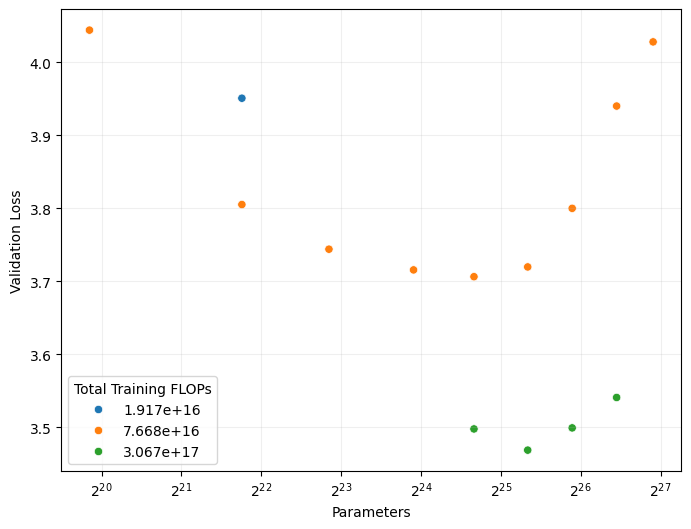

In [778]:
fig, ax = plt.subplots(figsize=(8, 6))

g = sns.scatterplot(
    data=min_results,
    x="params",
    y="min_valid_loss",
    hue="total_flops",
    ax=ax,
    palette="tab10",
)

ax.grid(which="major", alpha=0.20)

g.legend().set_title("Total Training FLOPs")

ax.set_xscale("log", base=2)
ax.set_xlabel("Parameters")
ax.set_ylabel("Validation Loss")

plt.show()